## Todo

- comparar leitos cnes com leitos api, ver se está muito fora
- medidas de desatualização por estado e tipo de gestão

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import requests
import seaborn as sns
import matplotlib
from pathlib import Path

In [2]:
# matplotlib.font_manager._rebuild()
# from matplotlib.font_manager import findfont, FontProperties
# font = findfont(FontProperties(family=['IBM Plex Sans']))
# font

In [3]:
# charts helpers

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this sets the python locale to pt_BR.UTF-8
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

OK_COLOR_SCALE_DIVERGING_COLORS = ['#00cb8d', '#99d9b1', '#eae4d6', '#e48fb0', '#d01c8c']
OK_COLOR_SCALE_DIVERGING = matplotlib.colors.LinearSegmentedColormap.from_list("", OK_COLOR_SCALE_DIVERGING_COLORS)
OK_PRIMARY = OK_COLOR_SCALE_DIVERGING_COLORS[0]

font_family = {'family':'IBM Plex Sans', 
               'weight': 'regular'
              }

factor = 1
SMALL_SIZE = 12 * factor
MEDIUM_SIZE = 14 * factor
BIGGER_SIZE = 18 * factor

S_LABEL_PAD = 10
M_LABEL_PAD = S_LABEL_PAD * 2

plt.rc('font', size=SMALL_SIZE, **font_family)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def increase_chart_margins(plt, plot_margin=0.15):
    x0, x1, y0, y1 = plt.axis()
    plt.axis((x0 - plot_margin,
              x1 + plot_margin,
              y0 - plot_margin,
              y1 + plot_margin))

def remove_chart_spines(ax, spines=['top', 'right', 'bottom', 'left']):
    for spine in spines:
        ax.spines[spine].set_visible(False)


def set_ticks(ax):
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE)


def set_grid_x(ax):
    ax.xaxis.grid(True, which='minor', zorder=-1, linestyle='-', linewidth=0)
    ax.xaxis.grid(True, which='major', zorder=-1, linestyle='-', linewidth=0.6)
    

def set_grid_y(ax):
    ax.yaxis.grid(True, which='major', zorder=-1, linestyle='-', linewidth=0.6)
    

def set_grid(ax):
    set_grid_x(ax)
    set_grid_y(ax)


def set_axis(ax):
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x).replace('.', ',')))
    ax.xaxis.label.set_visible(True)


def default_chart_configs(ax):
    increase_chart_margins(plt)
    remove_chart_spines(ax)
    set_ticks(ax)
    set_grid(ax)
    set_axis(ax)

## Ler dados

In [4]:
DATA_FOLDER = 'data/leitos/'

In [5]:
# data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
data_files = glob.glob(f'{DATA_FOLDER}data_*.csv.gz')
data_files.sort(reverse=True)
DATA_FILE = data_files[0]
print(DATA_FILE)

data/leitos/data_2021-03-09.csv.gz


In [6]:
# with gzip.open(DATA_FILE, 'r') as fin:
#     data = json.loads(fin.read().decode('utf-8'))
    
#     hits = data['hits']['hits']
#     df = pd.json_normalize(hits)

#     print(df.columns.values)
#     df.columns = [x.replace('_source.', '') for x in df.columns.values]

#     df.head()

In [7]:
# TS_RUN = pd.to_datetime(data['ts_run'])

In [8]:
df = pd.read_csv(DATA_FILE)

In [9]:
TS_RUN = pd.to_datetime(df.iloc[0]['ts_run'])

In [10]:
df.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run'],
      dtype=object)

## Limpar e criar features

In [120]:
# limpar siglas, muitas estão caixa baixa
df['estadoSigla'] = df['estadoSigla'].str.upper()

In [121]:
df = df.fillna({
    'ofertaHospCli': 0,
    'ofertaSRAGCli': 0,
    'ofertaHospUti': 0,
    'ofertaSRAGUti': 0,
    'ocupHospCli': 0,
    'ocupSRAGCli': 0,
    'ocupHospUti': 0,
    'ocupSRAGUti': 0,
})

### Considerando oferta sem ocupação

In [122]:
df['totalOfertaCli'] = df['ofertaHospCli'] + df['ofertaSRAGCli']
df['totalOfertaUti'] = df['ofertaHospUti'] + df['ofertaSRAGUti']
df['totalOcupCli'] = df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOcupUti'] = df['ocupHospUti'] + df['ocupSRAGUti']

### Considerando oferta como oferta + ocupação

In [123]:
df['totalOfertaCliAlt'] = df['ofertaHospCli'] + df['ofertaSRAGCli'] + df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOfertaUtiAlt'] = df['ofertaHospUti'] + df['ofertaSRAGUti'] + df['ocupHospUti'] + df['ocupSRAGUti']

### Tem UTI

Tem alguma vaga ou ocupação de UTI, Hosp ou SRAG

In [124]:
df['has_uti_proxy'] = np.where(df['totalOfertaUtiAlt'] > 0, True, False)

### Dados de atualização

In [125]:
df['dataNotificacaoOcupacao'] = pd.to_datetime(df['dataNotificacaoOcupacao'])

In [126]:
UPDATED_DAYS = [7, 14, 90]
for d in UPDATED_DAYS:
    df[f'updated_{str(d)}d'] = np.where(df['dataNotificacaoOcupacao'] >= TS_RUN - timedelta(days=d), True, False)

for d in UPDATED_DAYS:
    pct_outdated = len(df[df[f'updated_{str(d)}d'] == True]) / len(df)
    print(f'{round(pct_outdated * 100, 1)}% updated in {str(d)} days')

64.6% updated in 7 days
66.8% updated in 14 days
75.0% updated in 90 days


### Consulta CNES

In [127]:
STANDARD_HEADERS = {
    'Connection': 'keep-alive',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'Accept': 'application/json, text/plain, */*',
    'Referer': 'http://cnes.datasus.gov.br/pages/estabelecimentos/consulta.jsp',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36',
}

In [128]:
def get_basic_info_by_cnes(cnes):
    params = (
        ('cnes', cnes),
    )
    r = requests.get('http://cnes.datasus.gov.br/services/estabelecimentos', headers=STANDARD_HEADERS, params=params, verify=False)
    return json.loads(r.content)

In [129]:
def get_detailed_info(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [130]:
def get_beds(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-hospitalar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [131]:
def check_if_deactivated(id):
    # returns True is deactivated, false otherwise
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-desativados-local/validar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)['existe']

In [132]:
def get_all_info(cnes):
    basic_info = get_basic_info_by_cnes(cnes)
    # display(basic_info)
    first_match = basic_info[0]
    id = str(first_match['id'])

    beds = get_beds(id)
    detailed_info = get_detailed_info(id)
    deactivated = check_if_deactivated(id)
    
    detailed_info['beds'] = beds
    detailed_info['deactivated'] = deactivated
    return detailed_info

In [133]:
def get_all_hospital_data(df):
    ts_run = datetime.now(timezone.utc)
    cnes_codes = df[:].cnes.unique()
    counter = 1
    errors = []
    start_time = time.time()
    end_time = time.time()

    for cnes in cnes_codes:
        print(cnes, f'{counter}/{len(cnes_codes)}')
        file_path = f'data/hospitais/{cnes}.json'
        if Path(file_path).exists():
            print('--->file already exists, skipping')
            continue
        try:
            info = get_all_info(cnes)
            info['ts_run'] = ts_run.isoformat()
            info['error'] = False
            with open(file_path, 'w') as outfile:
                json.dump(info, outfile)
        except Exception as e:
            print('error:', e)
            errors.append(cnes)
            with open(file_path, 'w') as outfile:
                json.dump({'cnes': cnes, 'error': True}, outfile)
        finally:
            counter += 1

    time_elapsed = (end_time - start_time)
    print(time_elapsed)
    return errors

### Fazer consultas

In [134]:
# errors = get_all_hospital_data(df)
# with open(f'data/hospitais_errors.json', 'w') as outfile:
#     json.dump(errors, outfile)

In [135]:
# # ler arquivos baixados
# cnes_files = glob.glob('data/hospitais/*.json')

# frames = []
# for file_path in cnes_files:
#     with open(file_path) as f:
#         data = json.load(f)
#     if data['error'] == False:
#         frames.append(pd.json_normalize(data))

# df_hosp = pd.concat(frames)

In [136]:
# # salvar
# df_hosp.to_json('exports/hospitais_cnes.json', orient='records')

In [137]:
# ler resultado
dtypes = {
    'cnes': str  # has left padding zeros
}
df_hosp = pd.read_json('exports/hospitais_cnes.json', dtype=dtypes)

In [138]:
# # salvar
# import csv
# df_hosp.to_csv('exports/hospitais_cnes.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [139]:
# # ler resultado
# dtypes = {
#     'cnes': str  # has left padding zeros
# }
# df_hosp = pd.read_csv('exports/hospitais_cnes.csv', dtype=dtypes)

### Merge dados API e dados CNES

In [140]:
df_h = df.merge(df_hosp, on='cnes', suffixes=('', '_cnes'), how='left')

In [141]:
df_h.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'totalOfertaCli', 'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'has_uti_proxy',
       'updated_7d', 'updated_14d', 'updated_90d', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefone',
       'tpSempreAberto', 'coMotivoDesab', 'dsMotivoDesa

In [142]:
print('% which could not find CNES data', len(df_h[df_h.id.isna()]) / len(df_h))

% which could not find CNES data 0.06398537477148081


In [143]:
print('% which could not find CNES data AND updated last 14d', len(df_h[(df_h.id.isna()) & (df_h.updated_14d == True)]) / len(df_h))

% which could not find CNES data AND updated last 14d 0.005484460694698354


In [144]:
print('% with CNES data AND NOT updated last 14d', len(df_h[(df_h.id.notna()) & (df_h.updated_14d == False)]) / len(df_h))

% with CNES data AND NOT updated last 14d 0.2734395403499608


### Tentando diferenciar os desativados

- Não tem dados CNES & não foram atualizados nos últimos 14 dias
- OU Tem dados CNES & CNES == 'desativado' & não foram atualizados nos últimos 14 dias

In [145]:
df_deactivated = (df_h[
    ((df_h.id.isna()) & (df_h.updated_14d == False))
    |
    ((df_h.id.notna()) & (df_h.deactivated == True) & (df_h.updated_14d == False))
])
print(len(df_deactivated))

264


In [146]:
print('% deactivated', len(df_deactivated) / len(df_h))

% deactivated 0.06894750587620789


In [147]:
df_h['deactivated_proxy'] = np.where(df_h._id.isin(df_deactivated._id.unique()), True, False)

## Leitos CNES

In [148]:
all_beds = []
for index, row in df_h[df_h['beds'].notna()].iterrows():
    beds = row['beds']
    for bed in beds:
        bed['cnes'] = row['cnes']
        all_beds.append(bed)

In [149]:
df_beds = pd.DataFrame(all_beds)
df_beds.head()

,dsAtributo,coLeito,dsLeito,qtExistente,qtSus,cnes
0,ESPEC - CIRURGICO,03,CIRURGIA GERAL,3,1,2249626
1,ESPEC - CIRURGICO,06,GINECOLOGIA,1,1,2249626
2,ESPEC - CLINICO,32,CARDIOLOGIA,2,1,2249626
3,ESPEC - CLINICO,33,CLINICA GERAL,23,10,2249626
4,OBSTETRICO,10,OBSTETRICIA CIRURGICA,1,1,2249626


In [150]:
df_beds['total_beds'] = df_beds['qtExistente'].astype(float)

In [151]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo']).total_beds.sum().sort_values(ascending=False))

dsLeito                                                       dsAtributo  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR    20273.0
UTI ADULTO - TIPO II                                          COMPLEMENTAR    15735.0
UTI NEONATAL - TIPO II                                        COMPLEMENTAR     4896.0
UTI ADULTO - TIPO III                                         COMPLEMENTAR     3540.0
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR     2336.0
UTI ADULTO - TIPO I                                           COMPLEMENTAR     1856.0
UTI NEONATAL - TIPO III                                       COMPLEMENTAR      882.0
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR      784.0
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR      609.0
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR      540.0
UTI NEONATAL - TIPO I                                         COM

### Leitos tipo UTI

In [152]:
df_beds['uti'] = np.where(df_beds.dsLeito.str[0:3] == 'UTI', np.where(df_beds.dsLeito.str.contains('NEONATAL|QUEIMADOS') == False, True, False), False)

In [153]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo', 'uti']).total_beds.sum().sort_values(ascending=False))

dsLeito                                                       dsAtributo    uti  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR  True     20273.0
UTI ADULTO - TIPO II                                          COMPLEMENTAR  True     15735.0
UTI NEONATAL - TIPO II                                        COMPLEMENTAR  False     4896.0
UTI ADULTO - TIPO III                                         COMPLEMENTAR  True      3540.0
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR  True      2336.0
UTI ADULTO - TIPO I                                           COMPLEMENTAR  True      1856.0
UTI NEONATAL - TIPO III                                       COMPLEMENTAR  False      882.0
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR  True       784.0
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR  True       609.0
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR  True 

### Leitos CNES UTI

In [154]:
cnes_uti = df_beds[df_beds['uti'] == True].groupby('cnes').agg({'total_beds': 'sum'})
cnes_uti.reset_index(inplace=True)
cnes_uti.rename(columns={'total_beds': 'uti_beds_via_cnes'}, inplace=True)
cnes_uti.head()

,cnes,uti_beds_via_cnes
0,0000396,10.0
1,0000418,70.0
2,0000426,123.0
3,0000434,143.0
4,0000477,98.0


In [155]:
df_hb = df_h.merge(cnes_uti, on='cnes', how='left')

In [156]:
df_hb.head()

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,nuCompDesab,dtCarga,dtAtualizacaoOrigem,dtAtualizacao,beds,deactivated,ts_run_cnes,error,deactivated_proxy,uti_beds_via_cnes
0,leito_ocupacao,_doc,2249626,1.0,Rio Grande do Sul,RS,Estação,2249626,HOSPITAL SANTO ANTONIO ESTACAO,2021-03-05 06:40:51+00:00,...,NaN,02/03/2021,17/03/2003,06/08/2019,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
1,leito_ocupacao,_doc,2338386,1.0,Goiás,GO,Goiânia,2338386,FUNDACAO BANCO DE OLHOS DE GOIAS,2021-03-05 11:21:37+00:00,...,NaN,01/03/2021,30/10/2001,05/11/2020,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
2,leito_ocupacao,_doc,2384035,1.0,Goiás,GO,Santa Rosa de Goiás,2384035,HOSPITAL MUNICIPAL DE SANTA ROSA DE GOIAS,2021-03-05 07:54:52+00:00,...,NaN,25/02/2021,24/06/2003,09/02/2021,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
3,leito_ocupacao,_doc,2519356,1.0,Goiás,GO,Goiânia,2519356,MATERNIDADE MODELO,2021-03-05 09:13:53+00:00,...,NaN,01/03/2021,12/03/2002,05/04/2019,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
4,leito_ocupacao,_doc,2664836,1.0,Goiás,GO,Goiânia,2664836,NaN,2021-03-05 09:03:19+00:00,...,NaN,01/03/2021,08/04/2003,25/07/2019,[],False,2021-03-03T18:25:14.012835+00:00,False,False,NaN


In [157]:
df_hb['bed_diff'] = df_hb['totalOfertaUti'] - df_hb['uti_beds_via_cnes']
df_hb['bed_diff_alt'] = df_hb['totalOfertaUtiAlt'] - df_hb['uti_beds_via_cnes']

count    1535.000000
mean       -4.485993
std        18.080391
min      -178.000000
25%       -10.000000
50%        -1.000000
75%         0.000000
max       280.000000
Name: bed_diff, dtype: float64


<AxesSubplot:>

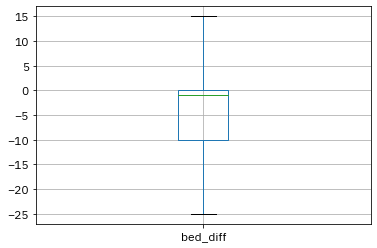

In [158]:
print(df_hb['bed_diff'].describe())
df_hb[['bed_diff']].boxplot(showfliers=False)

count    1535.000000
mean       25.637785
std        40.455028
min       -60.000000
25%         4.000000
50%        15.000000
75%        34.000000
max       435.000000
Name: bed_diff_alt, dtype: float64


<AxesSubplot:>

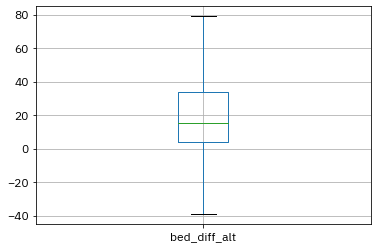

In [159]:
print(df_hb['bed_diff_alt'].describe())
df_hb[['bed_diff_alt']].boxplot(showfliers=False)

## Taxa de ocupação por estado

In [160]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

by_state = df_tmp.groupby('estado').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
})

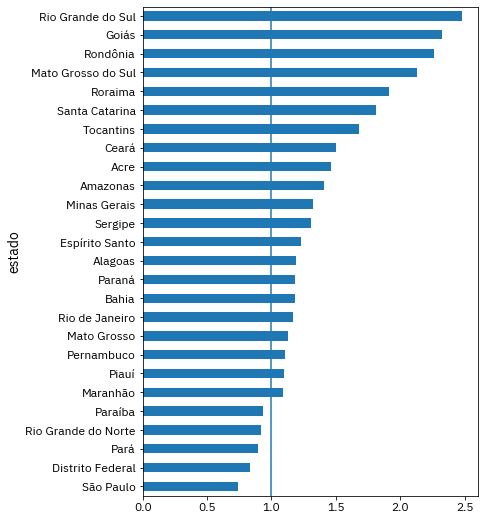

In [161]:
by_state['pct_occupied'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state[by_state['pct_occupied'] < 10]['pct_occupied'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

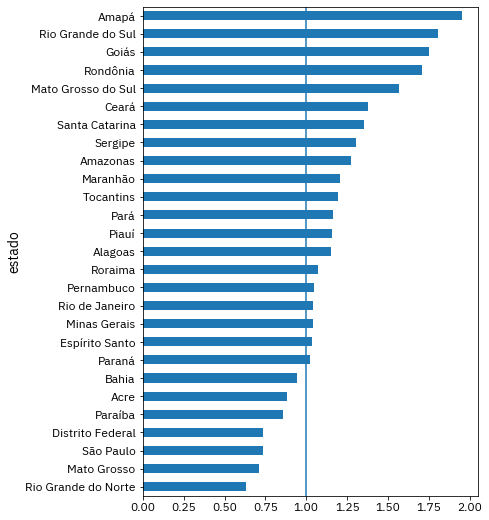

In [162]:
by_state['pct_occupied_cnes'] = by_state['totalOcupUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes'] < 10]['pct_occupied_cnes'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

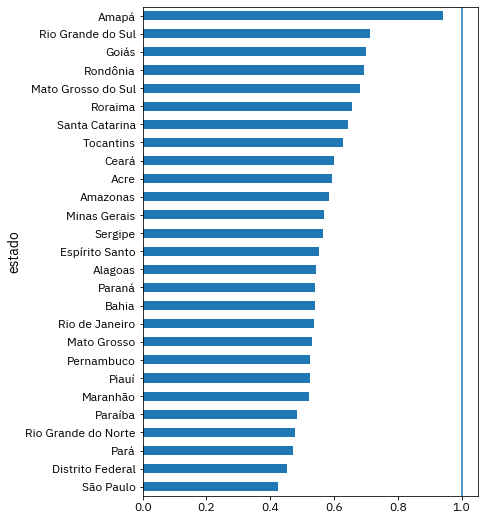

In [163]:
by_state['pct_occupied_alt'] = by_state['totalOcupUti'] / by_state['totalOfertaUtiAlt']
by_state[by_state['pct_occupied_alt'] < 10]['pct_occupied_alt'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

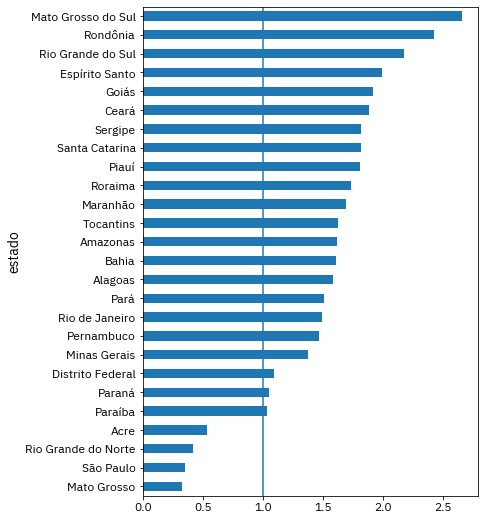

In [164]:
by_state['pct_occupied_hosp'] = by_state['ocupHospUti'] / by_state['ofertaHospUti']
by_state[by_state['pct_occupied_hosp'] < 10]['pct_occupied_hosp'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

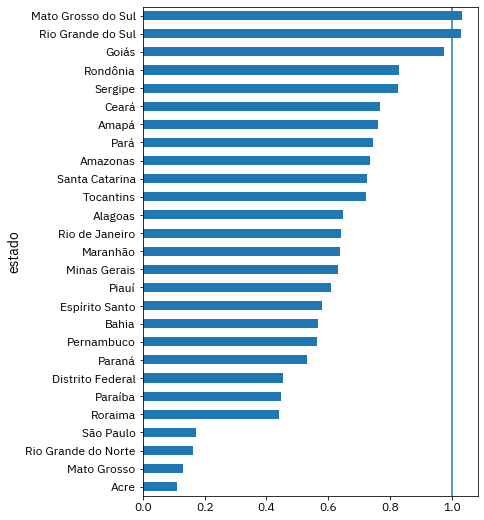

In [165]:
by_state['pct_occupied_cnes_hosp'] = by_state['ocupHospUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes_hosp'] < 10]['pct_occupied_cnes_hosp'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

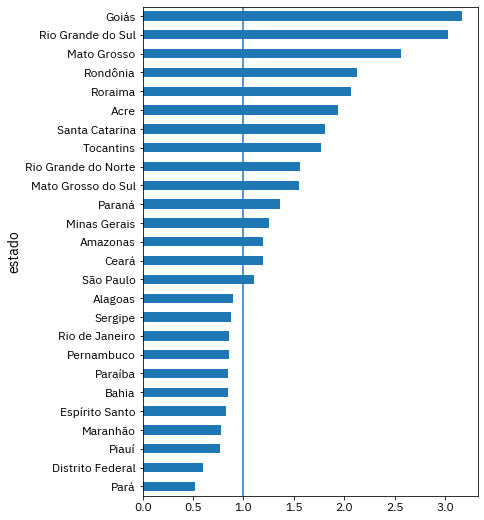

In [166]:
by_state['pct_occupied_srag'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state[by_state['pct_occupied_srag'] < 10]['pct_occupied_srag'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

In [167]:
by_state

,_id,uti_beds_via_cnes,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,ofertaHospUti,ocupHospUti,updated_7d,updated_14d,updated_90d,pct_occupied,pct_occupied_cnes,pct_occupied_alt,pct_occupied_hosp,pct_occupied_cnes_hosp,pct_occupied_srag
estado,,,,,,,,,,,,,,,,,,
Acre,2,126.0,76.0,187.0,111.0,50.0,97,26.0,14.0,1,1,2,1.460526,0.880952,0.593583,0.538462,0.111111,1.940000
Alagoas,17,452.0,439.0,960.0,521.0,255.0,229,184.0,292.0,9,9,14,1.186788,1.152655,0.542708,1.586957,0.646018,0.898039
Amapá,7,134.0,16.0,277.0,261.0,6.0,159,10.0,102.0,4,4,5,16.312500,1.947761,0.942238,10.200000,0.761194,26.500000
Amazonas,25,548.0,496.0,1194.0,698.0,247.0,295,249.0,403.0,12,14,21,1.407258,1.273723,0.584590,1.618474,0.735401,1.194332
Bahia,76,2349.0,1881.0,4099.0,2218.0,1051.0,886,830.0,1332.0,30,32,46,1.179160,0.944232,0.541108,1.604819,0.567050,0.843007
Ceará,60,1668.0,1536.0,3836.0,2300.0,858.0,1023,678.0,1277.0,27,27,30,1.497396,1.378897,0.599583,1.883481,0.765588,1.192308
Distrito Federal,17,774.0,687.0,1257.0,570.0,366.0,219,321.0,351.0,7,8,12,0.829694,0.736434,0.453461,1.093458,0.453488,0.598361
Espírito Santo,30,1263.0,1059.0,2363.0,1304.0,692.0,573,367.0,731.0,18,19,22,1.231350,1.032462,0.551841,1.991826,0.578781,0.828035
Goiás,116,1929.0,1451.0,4821.0,3370.0,471.0,1491,980.0,1879.0,105,107,109,2.322536,1.747019,0.699025,1.917347,0.974080,3.165605


## Athena

```sql
CREATE EXTERNAL TABLE IF NOT EXISTS datalake_medidasp.leitos (
  hits:array<struct<
    `_index`:string,
    `_type`:string,
    `_id`:string,
    `_score`:string,
    `_source.estado`:string,
    `_source.estadosigla`:string,
    `_source.municipio`:string,
    `_source.cnes`:string,
    `_source.nomecnes`:string,
    `_source.datanotificacaoocupacao`:string,
    `_source.ofertarespiradores`:string,
    `_source.ofertahospcli`:string,
    `_source.ofertahosputi`:string,
    `_source.ofertasragcli`:string,
    `_source.ofertasraguti`:string,
    `_source.ocuphospcli`:string,
    `_source.ocuphosputi`:string,
    `_source.ocupsragcli`:string,
    `_source.ocupsraguti`:string,
    `_source.altas`:string,
    `_source.obitos`:string,
    `_source.ocupacaoinformada`:string,
    `_source.algumaocupacaoinformada`:string>> 
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://medidasp/leitos/'
TBLPROPERTIES ('has_encrypted_data'='false');
```

## Dados com problemas de qualidade

In [190]:
df_hb['no_cnes_name'] = np.where(df_hb.nomeCnes.isna(), True, False)
df_hb['no_cnes_code'] = np.where(df_hb.cnes.isna(), True, False)
df_hb['no_matching_cnes'] = np.where(df_hb.id.isna(), True, False)
df_hb['icu_total_ocup_gt_offer'] = np.where((df['totalOcupUti'] > df['totalOfertaUti']) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_hosp_ocup_gt_offer'] = np.where((df['ocupHospUti'] > df['ofertaHospUti']) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_covid_ocup_gt_offer'] = np.where((df['ocupSRAGUti'] > df['ofertaSRAGUti']) & (df_hb.has_uti_proxy == True), True, False)
# invalid_cnes = ? 
# badly formatted integers ?

In [192]:
agg = {
    'cnes': 'count',
    'no_cnes_name': 'sum',
    'no_cnes_code': 'sum',
    'no_matching_cnes': 'sum',
    'icu_total_ocup_gt_offer': 'sum',
    'icu_hosp_ocup_gt_offer': 'sum',
    'icu_covid_ocup_gt_offer': 'sum',
}

df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]
by_state = df_tmp.groupby('estadoSigla').agg(agg)
by_state_pct = by_state.div(by_state['cnes'], axis=0)

<AxesSubplot:ylabel='estadoSigla'>

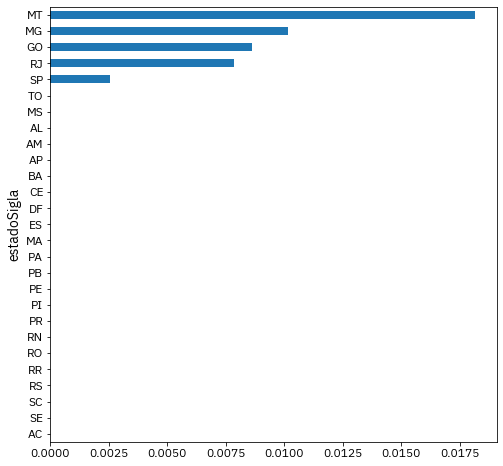

In [202]:
by_state_pct['no_matching_cnes'].sort_values().plot.barh(figsize=(8,8))

<AxesSubplot:ylabel='estadoSigla'>

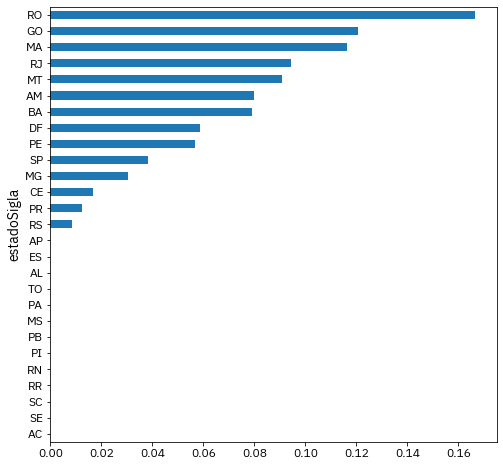

In [201]:
by_state_pct['no_cnes_name'].sort_values().plot.barh(figsize=(8,8))

<AxesSubplot:ylabel='estadoSigla'>

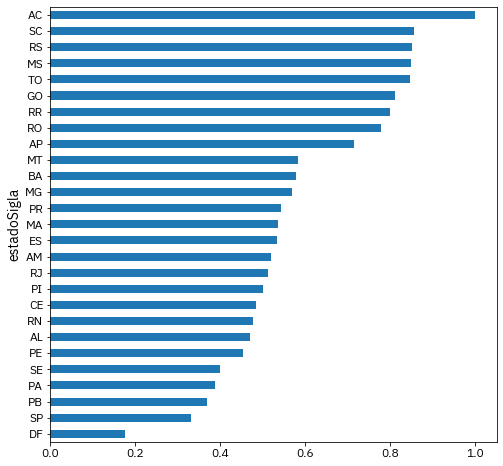

In [204]:
by_state_pct['icu_total_ocup_gt_offer'].sort_values().plot.barh(figsize=(8,8))

<AxesSubplot:ylabel='estadoSigla'>

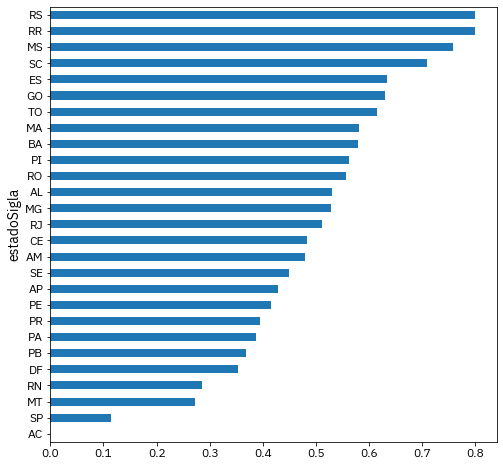

In [205]:
by_state_pct['icu_hosp_ocup_gt_offer'].sort_values().plot.barh(figsize=(8,8))

<AxesSubplot:ylabel='estadoSigla'>

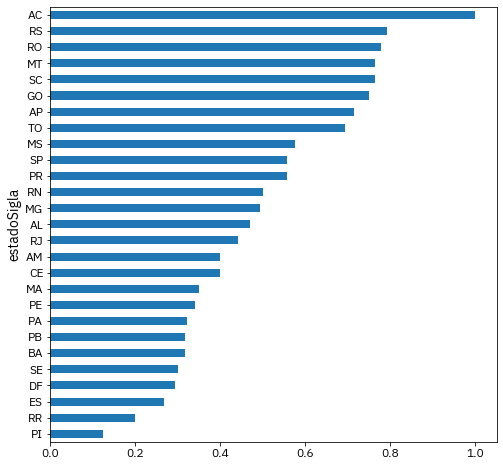

In [206]:
by_state_pct['icu_covid_ocup_gt_offer'].sort_values().plot.barh(figsize=(8,8))

## Desatualizados por estado

<AxesSubplot:ylabel='estado'>

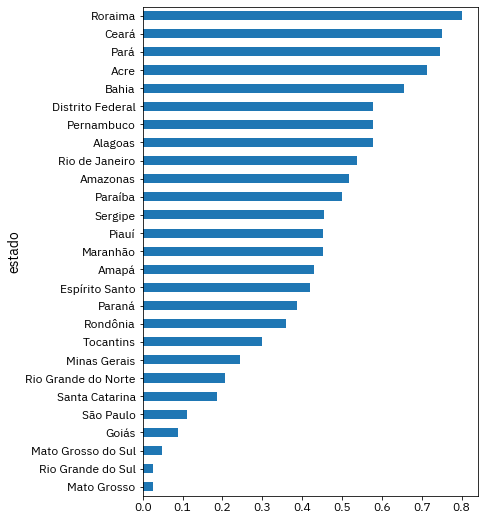

In [207]:
df_tmp = df_h[df_h['deactivated_proxy'] == False]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [208]:
len(df_h[df_h.has_uti_proxy == True]) / len(df_h)

0.4693131365891878

<AxesSubplot:ylabel='estado'>

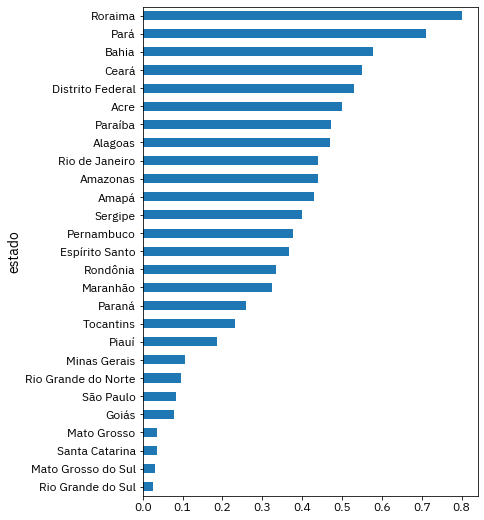

In [209]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

### Desatualizados por estado e tipo de gestão

In [210]:
df_h.groupby(['tpGestao', 'natJuridica']).size()

tpGestao  natJuridica
D         1.0             155
          2.0              29
          3.0             302
E         1.0             419
          2.0              40
          3.0             245
M         1.0            1247
          2.0             355
          3.0             791
          4.0               1
dtype: int64

In [211]:
types_natJuridica = {
    '1': 'ADMINISTRAÇÃO PÚBLICA',
    '2': 'ENTIDADES EMPRESARIAIS',
    '3': 'ENTIDADES SEM FINS LUCRATIVOS',
    '4': 'PESSOAS FÍSICAS', # claramente um erro 
}

types_tpGestao = {
    'D': 'Dupla',
    'E': 'Estadual',
    'M': 'Municipal',
}

<AxesSubplot:ylabel='estado,tpGestao'>

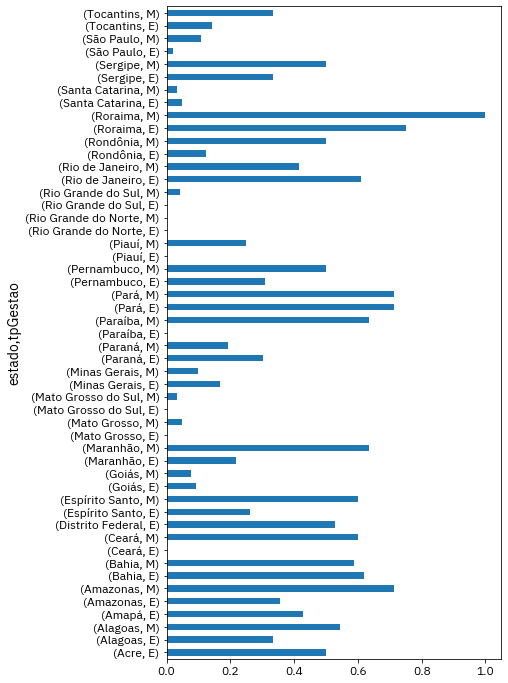

In [212]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
).plot.barh(figsize=(6,12))

In [213]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

df_tmp = (df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

df_tmp.reset_index().groupby(['tpGestao']).mean()

,0
tpGestao,
E,0.34314
M,0.39858


In [214]:
df_hb[df_hb.ocupHospUti % 1 != 0].ocupHospUti

160    37.6
Name: ocupHospUti, dtype: float64

In [215]:
df_hb[df_hb.ofertaHospUti % 1 != 0].ofertaHospUti

Series([], Name: ofertaHospUti, dtype: float64)

In [216]:
df_hb[df_hb.ocupSRAGUti % 1 != 0].ofertaHospUti

Series([], Name: ofertaHospUti, dtype: float64)

In [217]:
df_hb[df_hb.ofertaSRAGUti % 1 != 0].ofertaHospUti

Series([], Name: ofertaHospUti, dtype: float64)

## Comparação com leitos CNES

In [218]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]
df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}).reset_index()

<ipython-input-218-53876912aefd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()


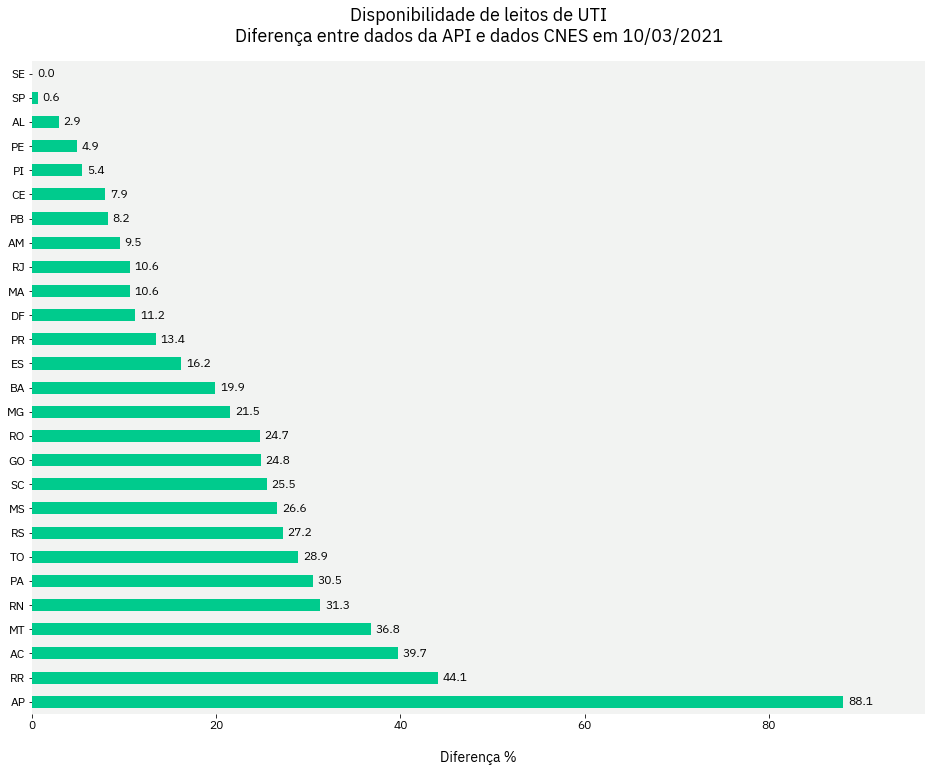

In [219]:
df_tmp = by_state.set_index('estadoSigla')
df_tmp['diff_uti_total_oferta'] = (df_tmp['totalOfertaUti'] / df_tmp['uti_beds_via_cnes']) - 1
df_tmp['diff_uti_total_oferta'] = round(abs(df_tmp[['diff_uti_total_oferta']]) * 100, 1)
df_tmp = df_tmp['diff_uti_total_oferta'].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(16,12))

df_tmp.plot.barh(ax=ax, color=OK_PRIMARY, zorder=3)

ax.set_xlim(0, round(df_tmp.max() * 1.1))
ax.set_facecolor('#f2f3f2')
# set_grid_x(ax)

ax.invert_yaxis()
ax.set_title('Disponibilidade de leitos de UTI\nDiferença entre dados da API e dados CNES em 10/03/2021', fontsize=BIGGER_SIZE, pad=M_LABEL_PAD)
ax.set_ylabel('')
ax.set_xlabel('Diferença %')
ax.xaxis.labelpad = M_LABEL_PAD


# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    label = str(round(width, 1))
    ax.annotate(label, xy=(left+width + 0.5, bottom+height/2), 
                ha='left', va='center')

# increase_chart_margins(plt)
remove_chart_spines(ax)
# set_ticks(ax)

# set_axis(ax)

## Comparação com Painéis Estaduais

In [220]:
# dados secretarias estaduais
df_ses = pd.read_csv('ses/dados_secretarias.csv', sep=',')

df_ses['data_consulta'] = df_ses['ts_consulta'].str[:10]
df_ses['data'] = np.where(df_ses.data_autalizacao.notna(), df_ses.data_autalizacao, df_ses.data_consulta)

df_ses.head()

,estado,ts_consulta,data_autalizacao,hora_atualizacao,obs,fonte,fonte_url,uti_total_oferta,uti_total_bloquada,uti_total_ocupada,...,uti_covid_total_bloqueada,pct_uti_covid_total_ocupada,uti_covid_adulto_oferta,uti_covid_adulto_ocupada,pct_uti_covid_adulto_ocupada,uti_covid_pediatrica_oferta,uti_covid_pediatrica_ocupada,pct_uti_covid_pediatrica_ocupada,data_consulta,data
0,MT,2021-03-10 10:52:00,2021-03-09,17:37:39,NaN,"Painel Covid-19, Secretaria do Estado de Saúde...",http://www.saude.mt.gov.br/painelcovidmt2/,498.0,4.0,475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
1,MA,2021-03-10 11:01:00,NaN,NaN,O painel é inconsistente internamente: em um l...,"Painel Coronavírus, Secretaria de Saúde",https://painel-covid19.saude.ma.gov.br/casos,NaN,NaN,NaN,...,NaN,0.853659,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10
2,BA,2021-03-10 11:06:00,2021-03-09,19:22:00,NaN,Painel SEI Covid,https://infovis.sei.ba.gov.br/covid19/,NaN,NaN,NaN,...,NaN,0.867878,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
3,PA,2021-03-10 11:11:00,NaN,NaN,Leitos são “Somente gestão do Governo do Estad...,NaN,https://www.covid-19.pa.gov.br/#/,NaN,NaN,NaN,...,NaN,0.761616,487.0,373.0,0.765914,8.0,4.0,0.5,2021-03-10,2021-03-10
4,PB,2021-03-10 11:16:00,2021-03-10,11:00:13,NaN,Gestão de Leitos Covid-19 Paraíba,https://superset.plataformatarget.com.br/super...,NaN,NaN,NaN,...,NaN,0.803738,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10


In [221]:
# estados sem dados
print('estados sem dados:', df_ses[(df_ses.uti_total_oferta.isna()) & (df_ses.uti_covid_total_oferta.isna())].estado.tolist())

estados sem dados: ['RJ']


In [222]:
df_ses.columns.values

array(['estado', 'ts_consulta', 'data_autalizacao', 'hora_atualizacao',
       'obs', 'fonte', 'fonte_url', 'uti_total_oferta',
       'uti_total_bloquada', 'uti_total_ocupada', 'pct_uti_total_ocupada',
       'uti_adulto_oferta', 'uti_adulto_bloqueada', 'uti_adulto_ocupada',
       'pct_uti_adulto_ocupada', 'uti_pediatrica_oferta',
       'uti_pediatrica_bloqueada', 'uti_pediatrica_ocupada',
       'pct_uti_pediatrica_ocupada', 'uti_covid_total_oferta',
       'uti_covid_total_ocupada', 'uti_covid_total_bloqueada',
       'pct_uti_covid_total_ocupada', 'uti_covid_adulto_oferta',
       'uti_covid_adulto_ocupada', 'pct_uti_covid_adulto_ocupada',
       'uti_covid_pediatrica_oferta', 'uti_covid_pediatrica_ocupada',
       'pct_uti_covid_pediatrica_ocupada', 'data_consulta', 'data'],
      dtype=object)

In [234]:
# calcular dados da api por estado, merge com dados secretarias estaduais
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]
df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}).reset_index()

by_state_ses = by_state.merge(df_ses, left_on='estadoSigla', right_on='estado', how='left')

by_state_ses['diff_uti_total_oferta'] = (by_state_ses['totalOfertaUti'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_total_ocup'] = (by_state_ses['totalOcupUti'] / by_state_ses['uti_total_ocupada']) - 1
by_state_ses['diff_uti_total_oferta_alt'] = (by_state_ses['totalOfertaUtiAlt'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_oferta'] = (by_state_ses['ofertaSRAGUti'] / by_state_ses['uti_covid_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_ocup'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['uti_covid_total_ocupada']) - 1

# taxas de ocupação
by_state_ses['pctTotalOcupUti'] = (by_state_ses['totalOcupUti'] / by_state_ses['totalOfertaUti'])
by_state_ses['pctSRAGOcupUti'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['ofertaSRAGUti'])
by_state_ses['diff_pct_uti_total_ocupada'] = (by_state_ses['pctTotalOcupUti'] / by_state_ses['pct_uti_total_ocupada']) - 1
by_state_ses['diff_pct_uti_covid_total_ocupada'] = (by_state_ses['pctSRAGOcupUti'] / by_state_ses['pct_uti_covid_total_ocupada']) - 1

<ipython-input-234-baf0698ddd1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()


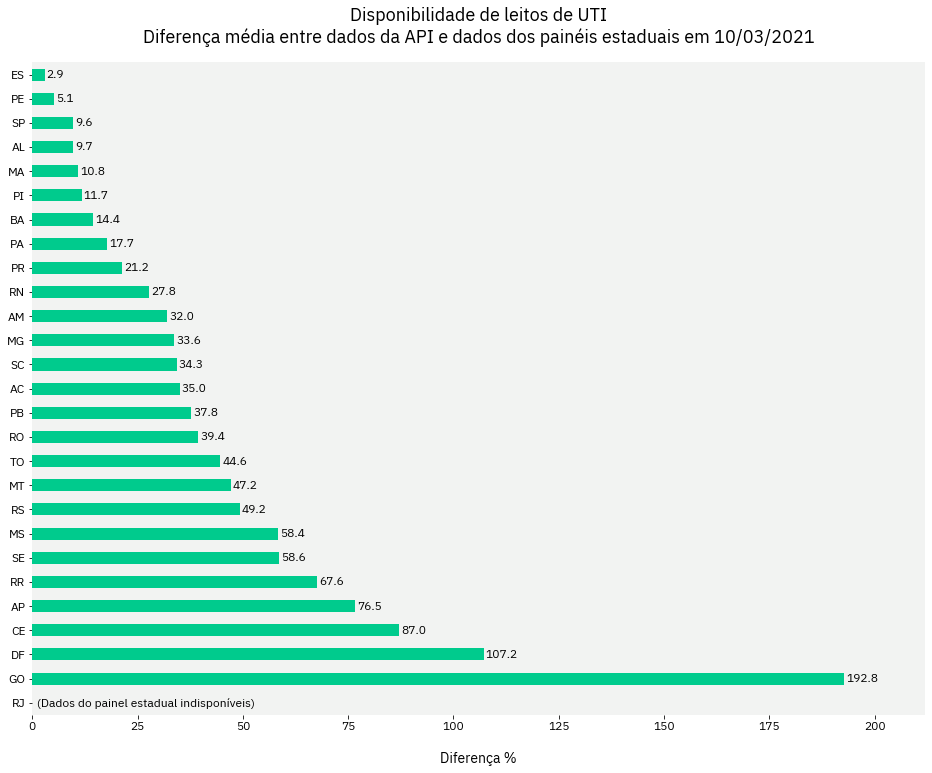

In [235]:
# diferença média por estado
cols = [
  'estadoSigla',
  'diff_uti_total_oferta',
  'diff_uti_total_ocup',
#   'diff_uti_total_oferta_alt',
  'diff_uti_covid_total_oferta',
  'diff_uti_covid_total_ocup',
]
df_tmp = by_state_ses[cols].set_index('estadoSigla')
df_tmp = abs(df_tmp)
df_tmp = round(df_tmp * 100, 1)
df_mean = df_tmp.T.mean().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(16,12))
df_mean.plot.barh(ax=ax, color=OK_PRIMARY, zorder=3)

ax.set_xlim(0, round(df_mean.max() * 1.1))
ax.set_facecolor('#f2f3f2')
# set_grid_x(ax)

ax.invert_yaxis()
ax.set_title('Disponibilidade de leitos de UTI\nDiferença média entre dados da API e dados dos painéis estaduais em 10/03/2021', fontsize=BIGGER_SIZE, pad=M_LABEL_PAD)
ax.set_ylabel('')
ax.set_xlabel('Diferença %')
ax.xaxis.labelpad = M_LABEL_PAD

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    label = str(round(width, 1))
    if width == 0:
        label = ' (Dados do painel estadual indisponíveis)'
    ax.annotate(label, xy=(left+width + 0.5, bottom+height/2), 
                ha='left', va='center')

remove_chart_spines(ax)

Text(0, -0.13, '*Células em cinza representam dados não disponíveis nos painéis estaduais')

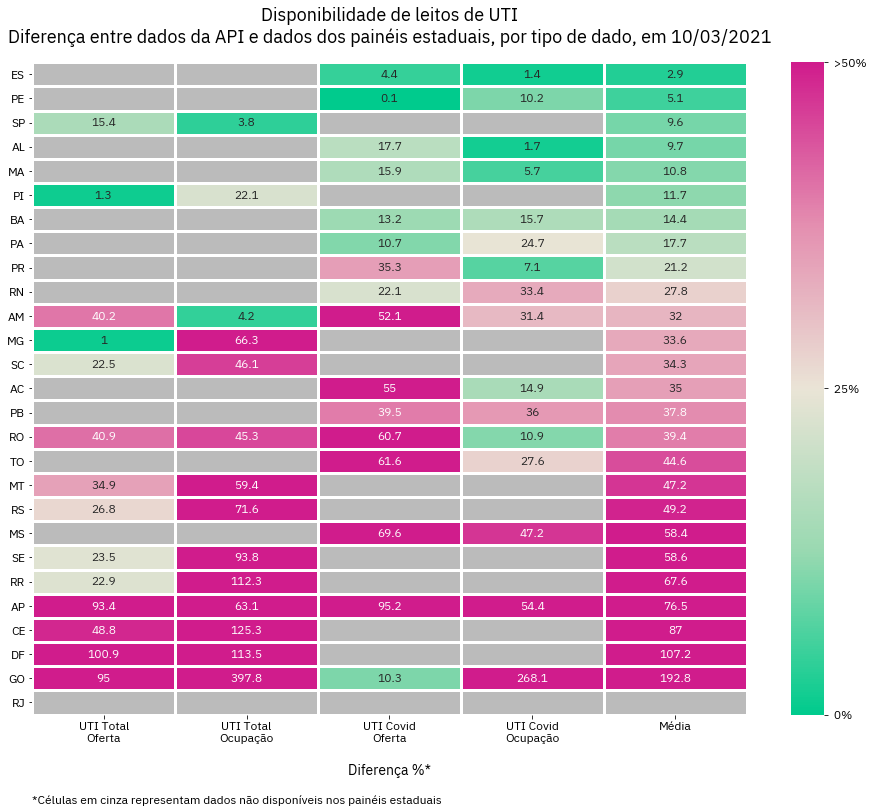

In [236]:
# diferença por estado por tipo de dado

# reorder to match df_mean order
df_heatmap = df_tmp.reindex(index=df_mean.reset_index()['estadoSigla'])
df_heatmap['diff_mean'] = round(df_mean, 1)
# plot
# color_scale = 'PiYG_r'
# color_scale = 'RdYlGn_r'
color_scale = OK_COLOR_SCALE_DIVERGING
xticklabels = [
    'UTI Total\nOferta',
    'UTI Total\nOcupação',
    'UTI Covid\nOferta',
    'UTI Covid\nOcupação',
    'Média',
]

fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df_heatmap, annot=True, ax=ax, cmap=color_scale, fmt='g', vmin=0, vmax=50, xticklabels=xticklabels)

ax.set_title('Disponibilidade de leitos de UTI\nDiferença entre dados da API e dados dos painéis estaduais, por tipo de dado, em 10/03/2021', fontsize=BIGGER_SIZE, pad=M_LABEL_PAD)
ax.set_ylabel('')
ax.set_xlabel('Diferença %*')
ax.set_facecolor('#bbbbbb')
ax.xaxis.labelpad = M_LABEL_PAD
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

for i in range(df_heatmap.shape[0] + 1):
    ax.axhline(i, color='white', lw=3)
for i in range(df_heatmap.shape[1] + 1):
    ax.axvline(i, color='white', lw=3)

    cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50])
cbar.set_ticklabels([' 0%', ' 25%', ' >50%'])
ax.text(0, -0.13,'*Células em cinza representam dados não disponíveis nos painéis estaduais',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)

In [237]:
# # reorder to match df_mean order
# df_heatmap = df_tmp.reindex(index=df_mean.reset_index()['estadoSigla'])
# # plot
# # color_scale = 'PiYG_r'
# # color_scale = 'RdYlGn_r'
# color_scale = OK_COLOR_SCALE_DIVERGING
# xticklabels = [
#     'UTI Total - Oferta',
#     'UTI Total - Ocupação',
#     'UTI Covid - Oferta',
#     'UTI Covid - Ocupação',
# ]

# fig, ax = plt.subplots(figsize=(12,12))
# sns.heatmap(df_heatmap, annot=True, ax=ax, cmap=color_scale, fmt='g', vmin=0, vmax=50, xticklabels=xticklabels)

# ax.set_title('Disponibilidade de leitos de UTI\nDiferença entre dados da API e dados dos painéis estaduais, por tipo de dado, em 10/03/2021', fontsize=BIGGER_SIZE, pad=M_LABEL_PAD)
# ax.set_ylabel('')
# ax.set_xlabel('Diferença %*')
# ax.set_facecolor('#bbbbbb')
# ax.xaxis.labelpad = M_LABEL_PAD
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# for i in range(df_heatmap.shape[0] + 1):
#     ax.axhline(i, color='white', lw=3)
# for i in range(df_heatmap.shape[1] + 1):
#     ax.axvline(i, color='white', lw=3)

#     cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 25, 50])
# cbar.set_ticklabels([' 0%', ' 25%', ' >50%'])
# ax.text(0, -0.11,'*Células em cinza representam dados não disponíveis nos painéis estaduais',
#      horizontalalignment='left',
#      verticalalignment='center',
#      transform = ax.transAxes)

### Taxas de ocupação

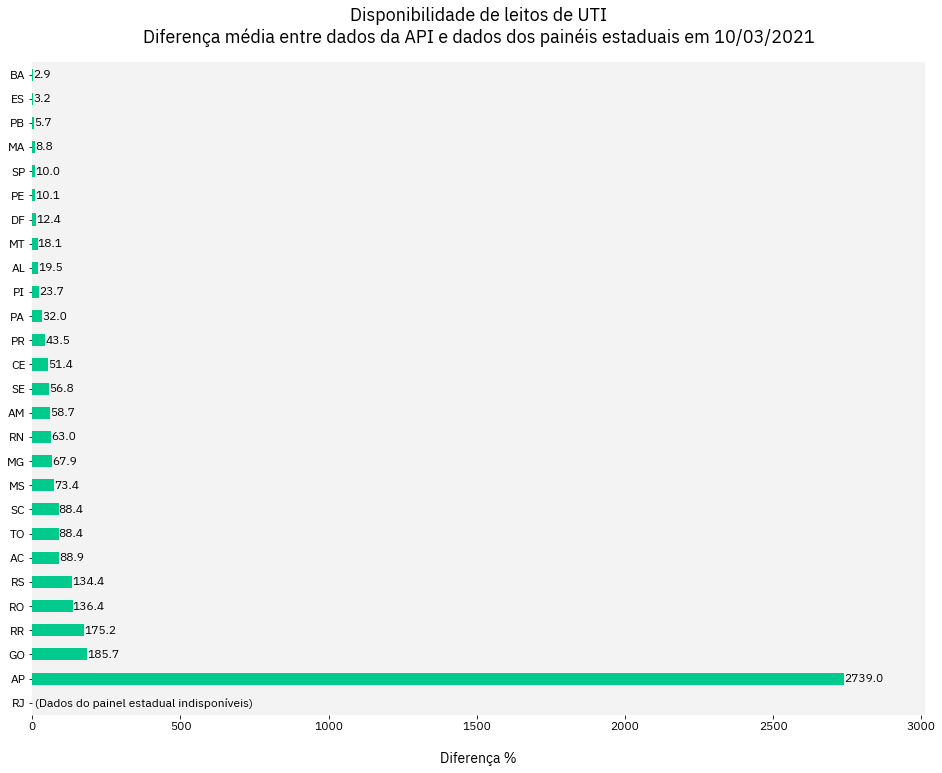

In [238]:
# diferença média por estado
cols = [
  'estadoSigla',
  'diff_pct_uti_total_ocupada',
  'diff_pct_uti_covid_total_ocupada',
]
df_tmp = by_state_ses[cols].set_index('estadoSigla')
df_tmp = abs(df_tmp)
df_tmp = round(df_tmp * 100, 1)
df_mean = df_tmp.T.mean().sort_values(ascending=True)
# df_mean = df_mean[df_mean < 1000]

fig, ax = plt.subplots(figsize=(16,12))
df_mean.plot.barh(ax=ax, color=OK_PRIMARY, zorder=3)

ax.set_xlim(0, round(df_mean.max() * 1.1))
ax.set_facecolor('#f2f3f2')
# set_grid_x(ax)

ax.invert_yaxis()
ax.set_title('Disponibilidade de leitos de UTI\nDiferença média entre dados da API e dados dos painéis estaduais em 10/03/2021', fontsize=BIGGER_SIZE, pad=M_LABEL_PAD)
ax.set_ylabel('')
ax.set_xlabel('Diferença %')
ax.xaxis.labelpad = M_LABEL_PAD

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    label = str(round(width, 1))
    if width == 0:
        label = ' (Dados do painel estadual indisponíveis)'
    ax.annotate(label, xy=(left+width + 0.5, bottom+height/2), 
                ha='left', va='center')

remove_chart_spines(ax)

Text(0, -0.13, '*Células em cinza representam dados não disponíveis nos painéis estaduais')

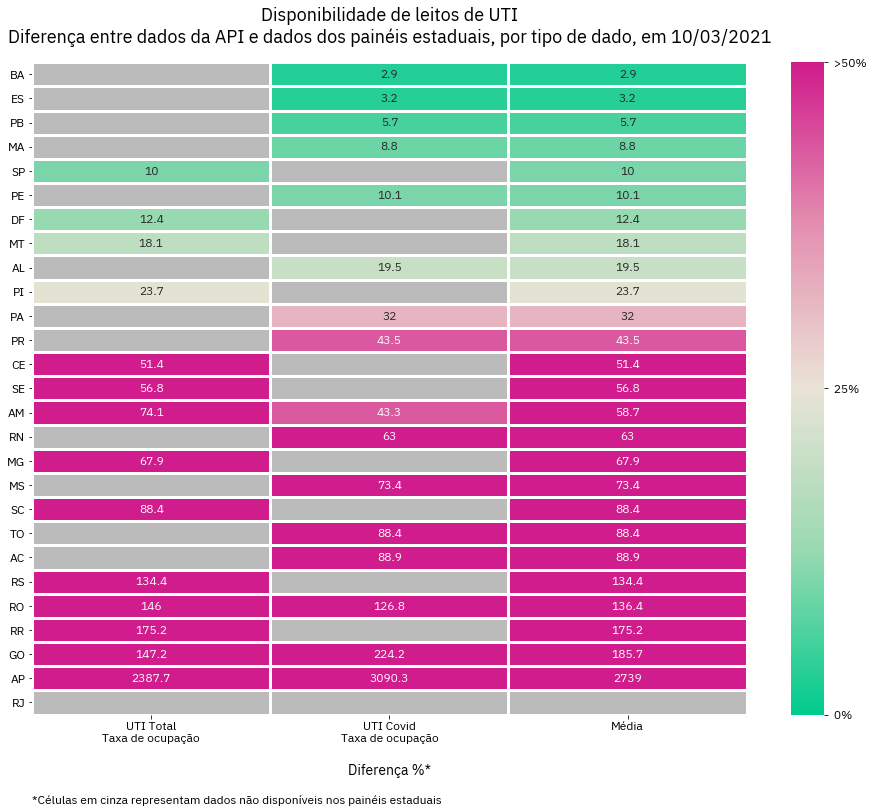

In [239]:
# diferença por estado por tipo de dado

# reorder to match df_mean order
df_heatmap = df_tmp.reindex(index=df_mean.reset_index()['estadoSigla'])
df_heatmap['diff_mean'] = round(df_mean, 1)
# plot
# color_scale = 'PiYG_r'
# color_scale = 'RdYlGn_r'
color_scale = OK_COLOR_SCALE_DIVERGING
xticklabels = [
    'UTI Total\nTaxa de ocupação',
    'UTI Covid\nTaxa de ocupação',
    'Média',
]

fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df_heatmap, annot=True, ax=ax, cmap=color_scale, fmt='g', vmin=0, vmax=50, xticklabels=xticklabels)

ax.set_title('Disponibilidade de leitos de UTI\nDiferença entre dados da API e dados dos painéis estaduais, por tipo de dado, em 10/03/2021', fontsize=BIGGER_SIZE, pad=M_LABEL_PAD)
ax.set_ylabel('')
ax.set_xlabel('Diferença %*')
ax.set_facecolor('#bbbbbb')
ax.xaxis.labelpad = M_LABEL_PAD
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

for i in range(df_heatmap.shape[0] + 1):
    ax.axhline(i, color='white', lw=3)
for i in range(df_heatmap.shape[1] + 1):
    ax.axvline(i, color='white', lw=3)

    cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50])
cbar.set_ticklabels([' 0%', ' 25%', ' >50%'])
ax.text(0, -0.13,'*Células em cinza representam dados não disponíveis nos painéis estaduais',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)

<AxesSubplot:ylabel='estadoSigla'>

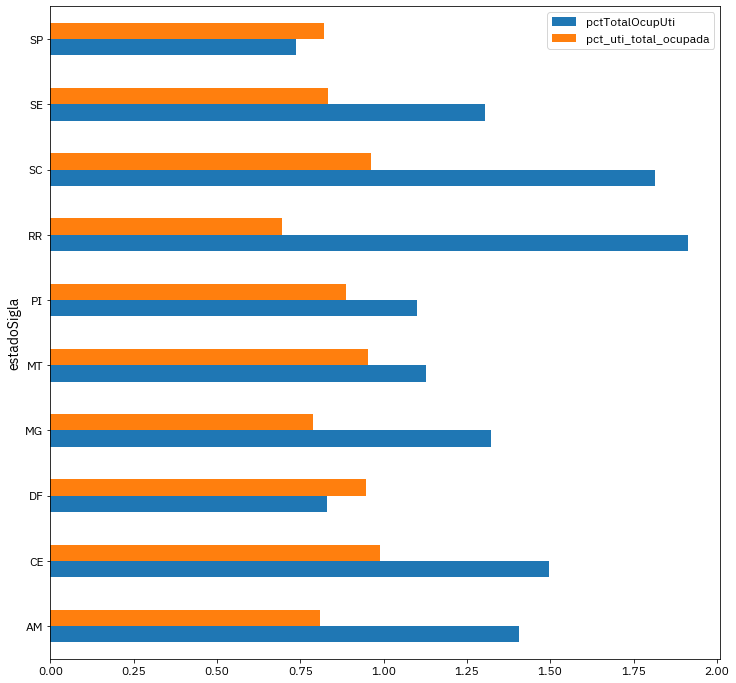

In [255]:
df_tmp = by_state_ses.set_index('estadoSigla')[[
    'pctTotalOcupUti',
    'pct_uti_total_ocupada',
]]
df_tmp = df_tmp[df_tmp.pctTotalOcupUti < 2]
df_tmp.dropna().plot.barh(figsize=(12,12))

<AxesSubplot:ylabel='estadoSigla'>

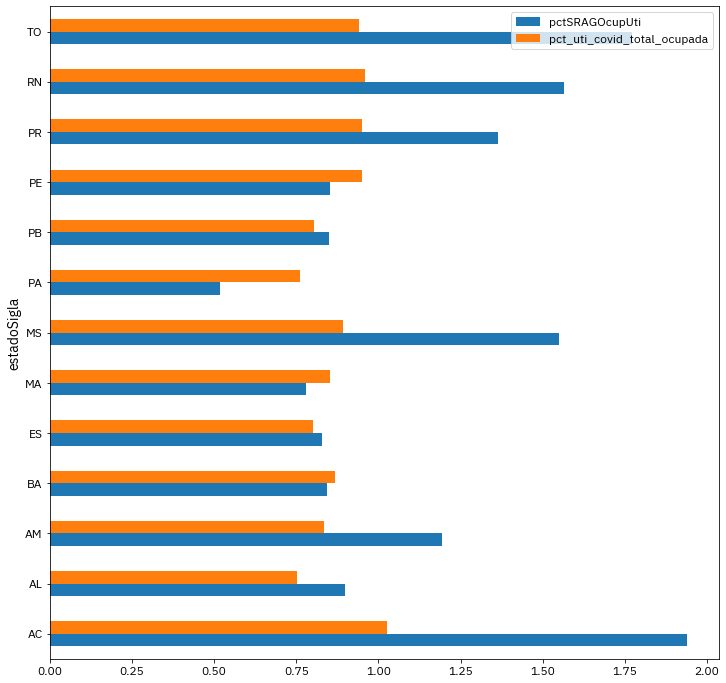

In [257]:
df_tmp = by_state_ses.set_index('estadoSigla')[[
    'pctSRAGOcupUti',
    'pct_uti_covid_total_ocupada',
]]

df_tmp = df_tmp[df_tmp.pctSRAGOcupUti < 2]
df_tmp.dropna().plot.barh(figsize=(12,12))

In [261]:
df[df.estadoSigla == 'AP'].totalOcupUti

576       0.0
2302      1.0
2509     45.0
2656      4.0
2658     22.0
2921    116.0
3676     73.0
Name: totalOcupUti, dtype: float64

In [262]:
df[df.estadoSigla == 'AP'].totalOfertaUti

576      1.0
2302     1.0
2509     4.0
2656     0.0
2658     0.0
2921    10.0
3676     0.0
Name: totalOfertaUti, dtype: float64

In [267]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_hb[df_hb.cnes == '2020653'].iloc[0])

_index                                                        leito_ocupacao
_type                                                                   _doc
_id                                                                  2020653
_score                                                                     1
estado                                                                 Amapá
estadoSigla                                                               AP
municipio                                                             Macapá
cnes                                                                 2020653
nomeCnes                                       SES AP HOSPITAL DE EMERGENCIA
dataNotificacaoOcupacao                     2021-02-10 03:00:52.102000+00:00
ofertaRespiradores                                                         5
ofertaHospCli                                                             98
ofertaHospUti                                                              6